# Building and AI football scouting agents with LangChain


### **About the project**  

In this notebook, we will demonstrate how to build a **multi-agent system** using LangChain for a **football scouting process**.  

The process involves 5 key components:  

##### Step 1: AI Scout Creation  
- Create multiple virtual scouts with varied experience, expertise, and areas of focus.

##### Step 2: News Retrieval  
- Query the web for relevant news articles based on the scouts' specific focus areas.

##### Step 3: Entity Extraction  
- Extract player names and associated teams from the retrieved content.

##### Step 4: Football Data API Integration  
- Access player statistics and performance data via a Football Data API.

##### Step 5: Expert Analysis  
- Analyze the gathered data and generate detailed reports on top football talent.




## install requirements

In [1]:
!pip install --quiet -U langgraph  langchain_experimental langchain_openai langchain_community langchain_core tavily-python wikipedia

### Set up credentials

In [1]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [5]:
_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [6]:
_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY: ··········


In [7]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [9]:
_set_env("FOOTBALL_API_KEY")

FOOTBALL_API_KEY: ··········


In [8]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "football-analyst"

## **1.Generate AI Scouts**  

In this section, we will create a list of fictional AI scouts using a streamlined workflow.  

The process involves:  
1. The AI generating an initial list of scouts.  
2. The user providing feedback to refine and improve the output.  

This approach can also be extended to automate the creation of an entire AI scout team.  

In [10]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import START,END, StateGraph
from langgraph.types import Command, interrupt

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,BaseMessage
from langchain_experimental.utilities import PythonREPL
from IPython.display import Image, display
from langchain_openai import ChatOpenAI


In [11]:
# Define the LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [12]:
# Define classes for Langgraph
class FootBallScout(BaseModel):
  name:str=Field(description="Name of the scout")
  location:str=Field(description="Location of the scout")
  description:str=Field(description="Description of the scout")

class ScoutingTeam(BaseModel):
  scouts: List[FootBallScout] = Field(
      description="Comprehensive list of scouts with their speciality and locations.",
  )
class GenerateScoutsState(TypedDict):
  leagues: List[str]
  topic: str
  max_scouts: int
  human_feedback: str
  scouts: List[FootBallScout]


In [13]:
create_scouts_instructions="""
You are tasked with creating a set of AI Football Scout personas. Follow these instructions carefully:

1. **Review the Topic**:
   Examine the provided topic: {topic}

2. **Assign Scouts to Leagues**:
   - Ensure each scout is assigned to one league from the list: {leagues}.
   -  Make sure to have exactly {max_scouts} scouts.
   - It is acceptable for multiple scouts to be assigned to the same league, but aim for diversity.

3. **Incorporate Feedback**:
   - Review any optional human feedback provided to guide the creation of scouts: {human_feedback}.

4. **Assign Scouts**:
   - Assign one scout persona to each selected theme (including expertise,focus and experiences).
   """

def create_scouts(state: GenerateScoutsState):
    """
    Create Scouts based on the provided state.

    """
    topic = state['topic']
    leagues = state["leagues"]
    max_scouts = state['max_scouts']
    human_feedback = state.get('human_feedback', '')

    # Enforce structured output with the LLM
    structured_llm = llm.with_structured_output(ScoutingTeam)

    # Format the system message using the instructions
    system_message = create_scouts_instructions.format(
        topic=topic,
        leagues=", ".join(leagues),  # Convert list of leagues to a readable string
        human_feedback=human_feedback,
        max_scouts=max_scouts
    )

    # Generate the scouts using the LLM
    scouts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the team of scouts.")]
    )

    # Return the generated scouts
    return {"scouts": scouts.scouts}

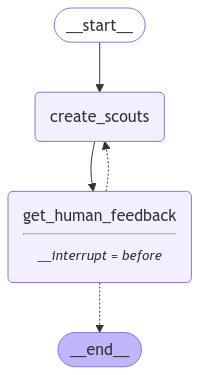

In [14]:
def get_human_feedback(state: GenerateScoutsState):
  pass

def should_continue(state: GenerateScoutsState):
  """ Return the next node to execute """

  # Check if human feedback
  human_feedback=state.get('human_feedback', None)
  if human_feedback:
    print("----------After Human Feedback--------------")
    return "create_scouts"

  # Otherwise end
  return END

# Add nodes and edges
builder = StateGraph(GenerateScoutsState)
builder.add_node("create_scouts", create_scouts)
builder.add_node("get_human_feedback", get_human_feedback)
builder.add_edge(START, "create_scouts")
builder.add_edge("create_scouts", "get_human_feedback")
builder.add_conditional_edges("get_human_feedback", should_continue, ["create_scouts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['get_human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### [Optional] Get human feedback and improve the results

In [15]:
# Input
topic = "Best young defenders in the Premier League for the 2024 season"
leagues = ["Spanish", "English", "French", "Italian", "Scottish", "Belgian", "German"]
thread = {"configurable": {"thread_id": "44"}}
max_scouts = 3

for event in graph.stream({"topic":topic,"max_scouts":max_scouts,"leagues":leagues}, thread, stream_mode="values"):
  scouting_team = event.get('scouts', '')
  if scouting_team:
      for scout in scouting_team:
          print(f"Name: {scout.name}")
          print(f"Location: {scout.location}")
          print(f"Description: {scout.description}")
          print("-" * 50)

Name: Carlos Martinez
Location: Spanish League
Description: Carlos is a seasoned scout with over 15 years of experience in the Spanish League. He has a keen eye for young defensive talent and has been instrumental in discovering several top-tier defenders who have made their mark in European football. His focus is on technical skills and tactical awareness, ensuring that the players he recommends can adapt to the fast-paced nature of the Premier League.
--------------------------------------------------
Name: Emily Thompson
Location: English League
Description: Emily is a former professional footballer turned scout, specializing in the English League. With a background in sports science, she combines her analytical skills with her on-field experience to identify young defenders who possess both physical prowess and mental resilience. Her expertise lies in evaluating players' potential to handle the pressures of top-flight football.
--------------------------------------------------
Nam

In [16]:
human_feedbak=input("Please provide a feedback on the results")
graph.update_state(thread, {"human_feedback": human_feedbak}, as_node="get_human_feedback")

Please provide a feedback on the results


{'configurable': {'thread_id': '44',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdd98f-a6a7-6655-8002-16f9e3ea1ca7'}}

In [17]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    scouting_team = event.get('scouts', '')
    if scouting_team:
        for scout in scouting_team:
            print(f"Name: {scout.name}")
            print(f"Location: {scout.location}")
            print(f"Description: {scout.description}")
            print("-" * 50)

Name: Carlos Martinez
Location: Spanish League
Description: Carlos is a seasoned scout with over 15 years of experience in the Spanish League. He has a keen eye for young defensive talent and has been instrumental in discovering several top-tier defenders who have made their mark in European football. His focus is on technical skills and tactical awareness, ensuring that the players he recommends can adapt to the fast-paced nature of the Premier League.
--------------------------------------------------
Name: Emily Thompson
Location: English League
Description: Emily is a former professional footballer turned scout, specializing in the English League. With a background in sports science, she combines her analytical skills with her on-field experience to identify young defenders who possess both physical prowess and mental resilience. Her expertise lies in evaluating players' potential to handle the pressures of top-flight football.
--------------------------------------------------
Nam


> We can see that the agent updated the scouts using the feedback



In [19]:
# Final review for our team
scouting_team

[FootBallScout(name='Carlos Martinez', location='Spanish League', description='Carlos is a seasoned scout with over 15 years of experience in the Spanish League. He has a keen eye for young defensive talent and has been instrumental in discovering several top-tier defenders who have made their mark in European football. His focus is on technical skills and tactical awareness, ensuring that the players he recommends can adapt to the fast-paced nature of the Premier League.'),
 FootBallScout(name='Emily Thompson', location='English League', description="Emily is a former professional footballer turned scout, specializing in the English League. With a background in sports science, she combines her analytical skills with her on-field experience to identify young defenders who possess both physical prowess and mental resilience. Her expertise lies in evaluating players' potential to handle the pressures of top-flight football."),
 FootBallScout(name='Jean-Luc Dupont', location='French Leagu

## **2. Implement the Football Expert Analysis Workflow**  

The expert analysis workflow consists of the following steps:  
- **Search the Web**: Gather accurate web pages related to the scouting topic.  
- **Extract Player Information**: Identify top players and their respective teams from the web pages.  
- **Fetch Player Stats**: Retrieve detailed player statistics using a football API.  
- **Analyze and Report**: Analyze the statistics and generate an insightful report.  



In [34]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(
    max_results=10,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False,
    )

In [21]:
import operator
from typing import  Annotated,Tuple
from langgraph.graph import MessagesState
import pandas as pd
import json


class Player(BaseModel):
  name:str=Field(description="Name of the player")
  team:str=Field(description="Team of the player")

class Players(BaseModel):
  players: List[Player] = Field(
      description="Player",)

class ReportState(MessagesState):
  topic:str
  scout:FootBallScout
  db_teams:json
  context: Annotated[list, operator.add] # Source docs
  league:str
  num_candidates:int
  candidates:list[str]
  stats: json
  report :str # final report

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [22]:
query_instructions = """
You are a helphul assistant, your will be asked by a football analyst to help him generate a well-structured web search query from his topic.
- Review his topic as well
- You query should be precise
- Your query should not be long 50 words max
the topic is {topic}
"""

def search_web(state: ReportState):

    """ Retrieve docs from web search """
    topic=state["topic"]
    scout=state["scout"]
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(query_instructions.format(topic=topic,persona=scout.description))
    print(f"-------------Search Query-----{search_query}")
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}


In [32]:
get_players_instructions = """
You are a helpful assistant tasked with analyzing news articles about football talents. Your objective is to extract the full name of the players mentioned in the news and their current team.

### Instructions:
1. Use only the information provided in the documents. Do not include any additional or inferred details.
2. If any information (e.g., team name) is missing, leave it blank.
3. Filter players to include only those who match the topic {topic}, ensuring their position and age align with the topic's requirements.
4. For each player, explicitly extract:
   - Full Name
   - Current Team
5. Make sure that the current team name is the official name of the team and not just an abrevation (e.g. Real Madrid and not RMA)
6. Make sure the Team name match a team in the dataset provided below

### Output Format:
- Player(name="player_name", team="team_name")

### Dataset:
{db_teams}
"""

def get_players(state: ReportState):
    """ Node to generate a question """

    context = state["context"]
    db_teams=state["db_teams"]
    system_message=get_players_instructions.format(db_teams=db_teams,topic=topic)
    candidates = llm.with_structured_output(Players).invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"the news you should use: {context}")])
    return {"candidates": [candidates]}

### Football Stats Section  

To retrieve football data, follow these steps:  

1. **Set Up API_FOOTBALL**  
   - Obtain an API key for **API_FOOTBALL**.  
   - Use the script provided [here](https://github.com/yassine-bouabda/football-stats-fetcher) to integrate it into your workflow.  

2. **Alternative Option**  
   - If you prefer not to use an API, you can use the dummy function provided below for demonstration purposes.  


In [24]:
import pandas as pd
from players_data import get_player_data  # get the helper from the github repo above

In [25]:
import random
def dummy_get_player_data(name, team):
    """Generates a dummy dataframe with player stats using an agent"""
    age=random.randint(18,30)
    position=random.choice(["Defender"])
    note=random.randint(1,10)
    goals=random.randint(0,30)
    assists=random.randint(0,30)
    clean_sheets=random.randint(0,10)
    minutes_played=random.randint(0,3000)
    result=pd.DataFrame({"name":[name],"team":team,"age":[age],"position":[position],
                         "note":[note],"goals":[goals],"assists":[assists],"clean_sheets":[clean_sheets],"minutes_played":[minutes_played]})
    return result

In [33]:
def stats_queries(state: ReportState):
  """Genrate simple queries to get players stats """

  candidates = state["candidates"][0].players
  all_stats=[]
  for candidate in candidates:
    name,team = candidate.name,candidate.team
    if not name and not team:
      continue
    print(f"--------Searching for {name}----------- ")
    stats=get_player_data(name,team)
    all_stats.append(stats)
  all_stats_df=pd.concat(all_stats)
  all_stats=all_stats_df.to_json(orient="records")
  return {"stats": [all_stats]}

In [28]:

# Expert analyst node
expert_instructions = """
You are an expert football analyst tasked with assisting a scout in generating a report on football talents. You will receive a JSON file containing seasonal statistics for a group of players.

Your responsibilities:
1. Review the information in the JSON
2. Use only the data available in the JSON for your analysis
3. Compare the players' statistics.
4. Select the top {num_candidates} players based on their stats.
5. Filter players to include only those who match the topic {topic}, ensuring their position and age align with the topic's requirements.
6. Generate a concise summary (maximum 200 words).
7. For each selected player:
   - Provide a brief recap highlighting their key strengths and performance.
   - Present their statistics in a structured table format.
8. DO NOT add player if he wasn't in the JSON
Structure your output in Markdown as follows:
- Title (`# Header`)
- Summary (`## Header`)
- Player Details (one section for each player, including a recap and data in table format):
  ```markdown
  ## Player 1
  ### Recap
  A short description summarizing the player's performance, strengths, and notable contributions.

  ### Player Data
  | Name              | Age | Team              | Goals | Assists | Clean Sheets | Minutes Played | Rating |
  |:------------------|:---:|:------------------|:-----:|:-------:|:------------:|:---------------:|:------:|
  | Player Name Here  |  XX | Team Name Here    |   XX  |    XX   |      XX      |       XX        |    XX   |

"""

def expert_reviewer(state: ReportState):
    stats=state["stats"]
    topic=state["topic"]
    num_candidates=state["num_candidates"]
    num_candidates=state["num_candidates"]
    """ Reveiw and summarize the talents documents """
    report=llm.invoke([SystemMessage(content=expert_instructions.format(num_candidates=num_candidates,topic=topic))]+[HumanMessage(content=f"Use this JSON data for your analysis {stats}")])
    print(report)
    return {"report": [report]}


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <module 'json' from '/usr/lib/python3.11/json/__init__.py'> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


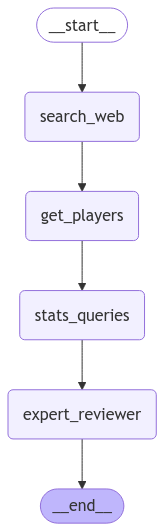

In [29]:

# Add nodes and edges
interview_builder = StateGraph(ReportState)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("get_players", get_players)
interview_builder.add_node("stats_queries", stats_queries)
interview_builder.add_node("expert_reviewer", expert_reviewer)

# Flow
interview_builder.add_edge(START, "search_web")
interview_builder.add_edge("search_web", "get_players")
interview_builder.add_edge("get_players", "stats_queries")
interview_builder.add_edge("stats_queries", "expert_reviewer")
interview_builder.add_edge("expert_reviewer", END)


# Interview
memory = MemorySaver()
scouting_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Football Scouting")

# View
display(Image(scouting_graph.get_graph().draw_mermaid_png()))

In [30]:
from IPython.display import Markdown
teams_df=pd.read_csv("all_teams.csv")
scout=scouting_team[0] # lets pick up the first scout as our virtuel scout
messages = [HumanMessage(f"Hello I am {scout.description} and I am looking for {topic}?")]
thread = {"configurable": {"thread_id": "999"}}
db_teams=teams_df[["Team"]].to_json(orient="records")
num_candidates=3
result = scouting_graph.invoke({"scout": scout, "messages": messages,"db_teams":db_teams,"num_candidates":num_candidates,"topic":topic}, thread)


-------------Search Query-----search_query='"Best young defenders Premier League 2024 season"'
['<Document href="https://www.footballtransfers.com/us/transfer-news/uk-premier-league/2024/09/ea-sports-fc-fifa-25-top-young-defenders-us"/>\nSep 26, 2024 · Lucas Beraldo (PSG), Luka Vuskovic (Westerlo), Ousmane Diomande (Sporting), Leny Yoro (Man Utd), Cristhian Mosquera (Valencia), Castello Lukeba\n</Document>\n\n---\n\n<Document href="https://sports.yahoo.com/premier-league-defenders-2024-25-210000365.html"/>\nAug 23, 2024 · Premier League defenders - 2024/25 power rankings · 10. Noussair Mazraoui · 9. Ben White · 8. Rico Lewis · 7. Gabriel · 6. Cristian Romero · 5. Ruben\xa0...Missing:  young | Show results with:young\n</Document>\n\n---\n\n<Document href="https://www.nytimes.com/athletic/5668414/2024/08/14/premier-league-young-player-to-watch/"/>\nAug 13, 2024 · Precocious midfielder Adam Wharton and defender Chadi Riad, who impressed on loan at Real Betis in La Liga last season, are mo

In [31]:
Markdown(result["report"][0].content)

# Best Young Defenders in the Premier League for the 2024 Season

## Summary
In the 2024 Premier League season, three young defenders have stood out: L. Yoro, R. Lewis, and L. Hall. These players, aged 20 and 21, have demonstrated significant potential and skill in their respective teams. L. Yoro, playing for Manchester United, has shown promise with his defensive capabilities despite limited appearances. R. Lewis of Manchester City has been a consistent performer, contributing both defensively and offensively. L. Hall from Newcastle has been a key player, showcasing his ability to maintain possession and contribute to the team's defensive solidity. These players have been selected based on their appearances, minutes played, and overall ratings, highlighting their importance to their teams and potential for future growth.

## Player 1: L. Yoro
### Recap
L. Yoro, at just 20 years old, has shown potential in his limited appearances for Manchester United. His defensive skills are evident through his tackling and dueling statistics, and he has maintained a solid presence on the field.

### Player Data
| Name    | Age | Team              | Goals | Assists | Clean Sheets | Minutes Played | Rating |
|:--------|:---:|:------------------|:-----:|:-------:|:------------:|:---------------:|:------:|
| L. Yoro |  20 | Manchester United |   0   |    0    |      -       |       419       | 6.52   |

## Player 2: R. Lewis
### Recap
R. Lewis has been a standout performer for Manchester City, contributing both defensively and offensively. His ability to assist and maintain a high pass completion rate makes him a valuable asset to his team.

### Player Data
| Name    | Age | Team              | Goals | Assists | Clean Sheets | Minutes Played | Rating |
|:--------|:---:|:------------------|:-----:|:-------:|:------------:|:---------------:|:------:|
| R. Lewis|  21 | Manchester City   |   1   |    2    |      -       |      1404       | 6.94   |

## Player 3: L. Hall
### Recap
L. Hall has been a key player for Newcastle, known for his defensive prowess and ability to maintain possession. His high number of duels and tackles highlights his defensive contributions.

### Player Data
| Name    | Age | Team     | Goals | Assists | Clean Sheets | Minutes Played | Rating |
|:--------|:---:|:---------|:-----:|:-------:|:------------:|:---------------:|:------:|
| L. Hall |  21 | Newcastle|   0   |    3    |      -       |      1745       | 7.31   |